## Mounting GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Applied\ AI\ course\ Assignments/Case\ Study\ 1

/content/drive/My Drive/Applied AI course Assignments/Case Study 1


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import pickle
import gc
import warnings
warnings.filterwarnings('ignore')

#plt.style.use('dark_background')

## Script to reduce memory usage

In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Checking the collinearity of features

Removing the Nan, inf and -inf values and filling them with mean values

In [ ]:
train = reduce_mem_usage(pd.read_csv('New_Data_processed/train_features_without_merchant.csv', index_col=0))
test = reduce_mem_usage(pd.read_csv('New_Data_processed/test_features_without_merchant.csv', index_col=0))

Mem. usage decreased to 99.94 Mb (71.4% reduction)
Mem. usage decreased to 62.01 Mb (70.9% reduction)


In [ ]:
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

In [ ]:
train.columns[train.isna().any()]

Index(['transactions_duration_skew', 'transactions_price_sum',
       'transactions_price_skew', 'new_transactions_duration_skew',
       'new_transactions_price_sum', 'new_transactions_price_mean',
       'new_transactions_price_min', 'new_transactions_price_max',
       'purchase_amount_ratio', 'installments_ratio'],
      dtype='object')

In [ ]:
test.columns[test.isna().any()]

Index(['target', 'transactions_duration_skew', 'transactions_price_sum',
       'transactions_price_skew', 'new_transactions_duration_skew',
       'new_transactions_price_sum', 'new_transactions_price_mean',
       'new_transactions_price_min', 'new_transactions_price_max',
       'new_purchase_date_diff_now', 'new_last_buy', 'installments_ratio'],
      dtype='object')

In [ ]:
#Imputing the inf values from nan to mode/mean

train['transactions_duration_skew'].fillna(train['transactions_duration_skew'].mean(), inplace=True)
test['transactions_duration_skew'].fillna(test['transactions_duration_skew'].mean(), inplace=True)
train['transactions_price_sum'].fillna(train['transactions_price_sum'].mean(), inplace=True)
test['transactions_price_sum'].fillna(test['transactions_price_sum'].mean(), inplace=True)
train['transactions_price_skew'].fillna(train['transactions_price_skew'].mean(), inplace=True)
test['transactions_price_skew'].fillna(test['transactions_price_skew'].mean(), inplace=True)
train['new_transactions_duration_skew'].fillna(train['new_transactions_duration_skew'].mean(), inplace=True)
test['new_transactions_duration_skew'].fillna(test['new_transactions_duration_skew'].mean(), inplace=True)
train['new_transactions_price_mean'].fillna(train['new_transactions_price_mean'].mean(), inplace=True)
test['new_transactions_price_mean'].fillna(test['new_transactions_price_mean'].mean(), inplace=True)
train['new_transactions_price_sum'].fillna(train['new_transactions_price_sum'].mean(), inplace=True)
test['new_transactions_price_sum'].fillna(test['new_transactions_price_sum'].mean(), inplace=True)
train['new_transactions_price_min'].fillna(train['new_transactions_price_min'].mean(), inplace=True)
test['new_transactions_price_min'].fillna(test['new_transactions_price_min'].mean(), inplace=True)
train['new_transactions_price_max'].fillna(train['new_transactions_price_max'].mean(), inplace=True)
test['new_transactions_price_max'].fillna(test['new_transactions_price_max'].mean(), inplace=True)

train['purchase_amount_ratio'].fillna(train['purchase_amount_ratio'].mean(), inplace=True)

test['new_purchase_date_diff_now'].fillna(test['new_purchase_date_diff_now'].mode()[0], inplace=True)

train['installments_ratio'].fillna(train['installments_ratio'].mean(), inplace=True)
test['installments_ratio'].fillna(test['installments_ratio'].mean(), inplace=True)

test['new_last_buy'].fillna(test['new_last_buy'].mode()[0], inplace=True)

In [ ]:
train.columns[train.isna().any()]

Index([], dtype='object')

In [ ]:
test.columns[test.isna().any()]

Index(['target'], dtype='object')

In [ ]:
train.head()

,card_id,feature_1,feature_2,feature_3,target,quarter_first_active_month,first_active_month_diff_from_today,rare_datapoints,cat_time_feature1,cat_time_feature2,cat_time_feature3,cat_time_ratio1,cat_time_ratio2,cat_time_ratio3,feature_sum,feature_mean,feature_max,feature_min,feature_std,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,days_feature_3_ratio,transactions_is_weekend_sum,transactions_is_weekend_mean,transactions_purchase_on_holiday_sum,transactions_purchase_on_holiday_mean,transactions_weekday_nunique,transactions_weekday_sum,transactions_weekday_mean,transactions_purchase_hour_nunique,transactions_purchase_hour_mean,transactions_purchase_hour_min,transactions_purchase_hour_max,transactions_week_of_year_nunique,transactions_week_of_year_mean,transactions_week_of_year_min,transactions_week_of_year_max,...,new_transactions_price_skew,purchase_date_diff,new_purchase_date_diff,purchase_date_average,new_purchase_date_average,purchase_date_diff_now,new_purchase_date_diff_now,purchase_date_diff_now_min,new_purchase_date_diff_now_min,first_buy,new_first_buy,last_buy,new_last_buy,card_id_total,card_id_ratio,purchase_amount_total,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_ratio,month_diff_mean,month_diff_ratio,month_lag_mean,month_lag_max,month_lag_min,category_1_mean,category_1_sum,installments_mean,installments_total,installments_ratio,installments_max,installments_min,duration_mean,duration_max,duration_min,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,CLV,new_CLV
0,C_ID_92a2005557,0.013145,0.008751,0.011429,-0.820312,2,1215,0,15.968750,10.632812,13.882812,0.000011,0.000007,0.000009,0.033325,0.011108,0.013145,0.008751,0.002214,15.968750,0.000011,10.632812,0.000007,13.882812,0.000009,90,0.346191,8,0.030762,7,835,3.210938,23,13.312500,0,23,35,33.06250,1,52,...,1.732422,243,55.0,0.934570,2.390625,949,886,1192,941.0,26,277.0,269,332,283.0,0.088440,-180.62500,-1.219727,0.503906,-1.463867,0.07910,63.00000,1.000977,-2.433594,2.0,-7.0,0.000000,0.0,0.015381,4.0,0.00000,1.0,0.0,-38.37500,16.406250,-46.68750,-0.038757,-0.047180,0.015747,-1382.193604,-9.664062
1,C_ID_3d0044924f,0.010712,0.011383,0.010284,0.392822,1,1366,0,14.632812,15.554688,14.046875,0.000008,0.000008,0.000008,0.032379,0.010796,0.011383,0.010284,0.000556,14.632812,0.000008,15.554688,0.000008,14.046875,0.000008,132,0.377197,17,0.048584,7,1177,3.363281,24,14.718750,0,23,50,25.21875,1,52,...,1.203125,390,57.0,1.114258,9.500000,974,916,1364,973.0,5,396.0,395,453,356.0,0.017136,-219.75000,-1.341797,0.098145,-1.481445,0.02022,64.87500,1.002930,-3.531250,2.0,-11.0,0.088562,31.0,2.558594,551.0,0.01101,11.0,1.0,-43.53125,3.953125,-48.84375,-0.041321,-0.046143,0.003067,-2326.133057,-0.804199
2,C_ID_d639edf6cd,0.010612,0.008751,0.010284,0.687988,3,1519,0,16.109375,13.296875,15.617188,0.000007,0.000006,0.000007,0.029648,0.009880,0.010612,0.008751,0.000992,16.109375,0.000007,13.296875,0.000006,15.617188,0.000007,11,0.255859,3,0.069763,7,142,3.302734,14,17.906250,8,23,22,18.37500,2,49,...,1.732422,412,0.0,9.578125,0.000000,947,887,1359,887.0,163,635.0,575,635,44.0,0.023254,-29.87500,-1.378906,-0.846191,-1.429688,0.02400,62.31250,0.989746,-6.601562,2.0,-11.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,-42.93750,-26.218750,-45.03125,-0.044250,-0.046143,-0.027283,-40.040398,-0.022583
3,C_ID_186d6a6901,0.010712,0.014168,0.010284,0.142456,3,1123,0,12.031250,15.906250,11.546875,0.000010,0.000013,0.000009,0.035156,0.011719,0.014168,0.010284,0.002129,12.031250,0.000010,15.906250,0.000013,11.546875,0.000009,11,0.142822,0,0.000000,7,215,2.792969,16,14.445312,0,23,20,32.00000,1,52,...,1.732422,155,42.0,2.013672,6.000000,946,897,1101,939.0,25,187.0,180,229,84.0,0.090881,-54.78125,-1.316406,0.232910,-1.474609,0.09290,62.96875,1.005859,-1.118164,2.0,-4.0,0.298828,13.0,1.974609,92.0,0.06976,4.0,0.0,-41.37500,7.218750,-47.12500,-0.041901,-0.046997,0.007523,-122.954704,-1.032227
4,C_ID_cdbd2c0db2,0.008057

In [ ]:
train_card_ids = train['card_id']
train_target = train['target']
train_rare_points = train['rare_datapoints']
train.drop(columns=['card_id', 'target', 'rare_datapoints'],axis=1 ,inplace=True)

In [ ]:
test_card_ids = test['card_id']
test_target = test['target']
test.drop(columns=['card_id', 'target'],axis=1 ,inplace=True)

### Using Correlation matrix

In [ ]:
col_matrix = train.corr()

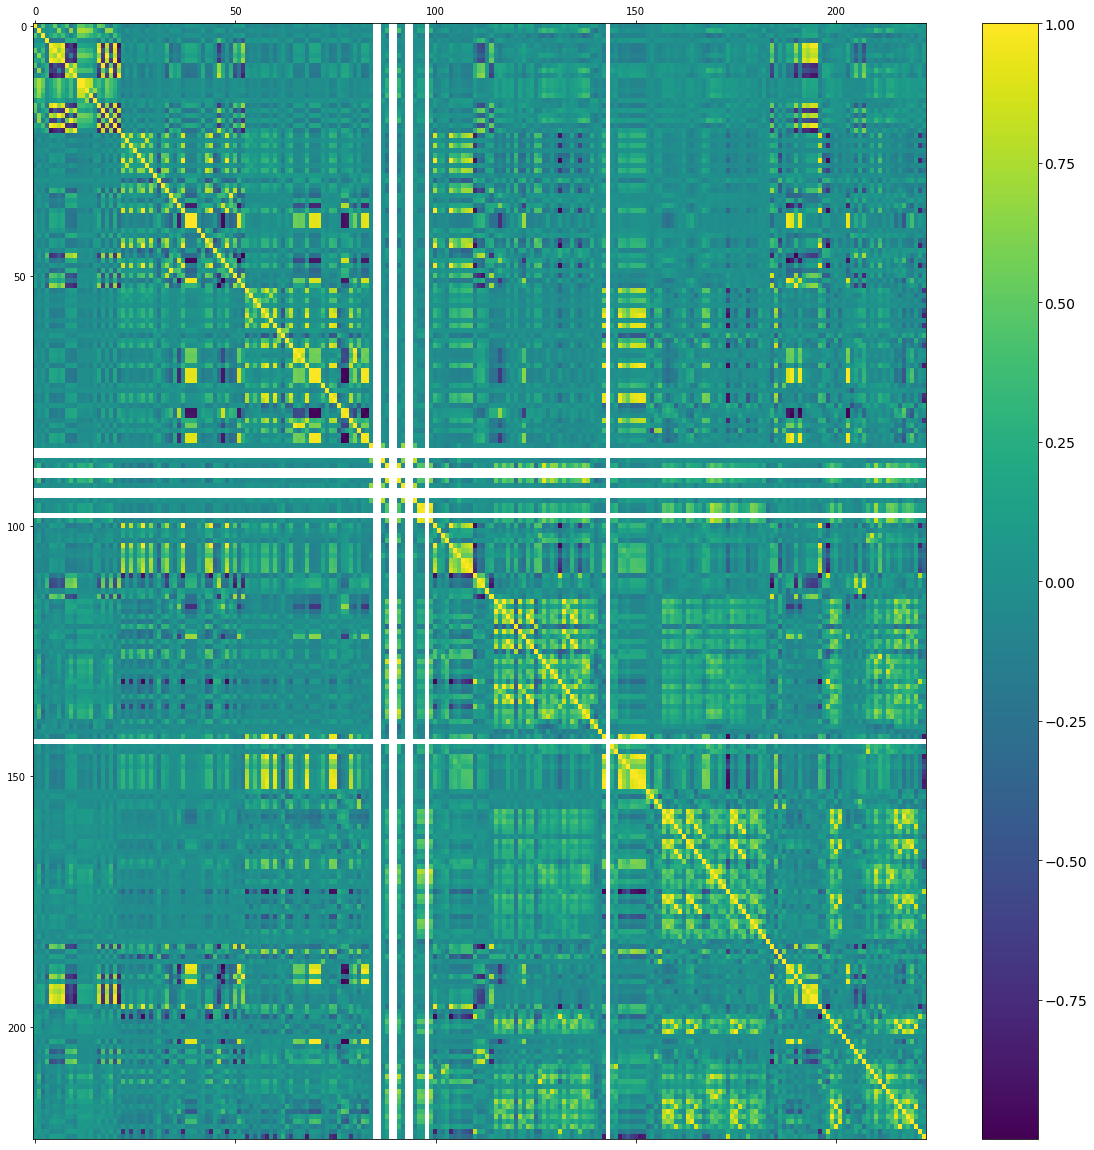

In [ ]:
plt.figure(figsize=(20,20))
plt.matshow(col_matrix, fignum=1, aspect='auto')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.savefig('correlation_matrix.png')
plt.show()

We cannot interpret anything from this. 
<br>
Let's check the correlation of all these features with our loyalty score(target variable).

<h3> Unstacking and sorting </h3>

Lets unstack these values and sort the pairs with highest correlations.

Reference: https://likegeeks.com/python-correlation-matrix/

In [ ]:
corr_pairs = col_matrix.unstack()

In [ ]:
sorted_pairs = corr_pairs.sort_values(kind="quicksort")

Selecting pairs with correlation value > 0.85

In [ ]:
pairs_with_high_corr = sorted_pairs[(sorted_pairs > 0.85)]

In [ ]:
len(pairs_with_high_corr)

831

Lets remove one feature from the highly correlated fature pairs

In [ ]:
#https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    #print(dataset)

In [ ]:
correlation(train, 0.85)

In [ ]:
len(train.columns)

134

In [ ]:
test = test[train.columns]

In [ ]:
len(test.columns)

134

In [ ]:
train['card_id'] = train_card_ids
train['target'] = train_target
train['rare_datapoints'] = train_rare_points

test['card_id'] = test_card_ids
test['target'] = test_target

In [ ]:
# Saving the final Data frames for modeling
train.to_csv('New_Data_processed/train_selected_features.csv')
test.to_csv('New_Data_processed/test_selected_features.csv')

## Conclusion:

Out of the 223 features generated, we have selected 134 features that would help in predicting the loyalty scores using regression models.